# 138 Final Project (Sp 25)
- By Jenny Chen

In [1]:
import numpy as np
import qutip as qt
import math
import scipy
import matplotlib.pyplot as plt
import scienceplots as splt
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from scipy.constants import *

In [2]:
plt.style.use('science')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# STIRAP
- Derivations are done in the rotating frame (RWA)
- The goal is to adiabatically drive the system from $\psi_1$ to $\psi_3$ without losing any population to $\psi_2$, which can radiatively decay to inaccessible states through spontaneous emission

$$H = \hbar \begin{pmatrix}
0 & \frac{1}{2}\Omega_p(t) & 0\\
\frac{1}{2}\Omega_p(t) & \Delta_p & \frac{1}{2}\Omega_s(t)\\
0 & \frac{1}{2}\Omega_s(t) & \Delta_p - \Delta_s\\
\end{pmatrix}$$
- The ideal pulse sequence looks like the following
<div>
<img src="img/pulse_sequence_vitanov2001.png" width=500 height=200 />
</div>
- Furthermore, a crucial assumption is that there is two photon resonance ($\Delta_p - \Delta_s = 0$)
- Adiabatic condition: $\Omega_0^2 T > \frac{100}{T}$ or equivalently $T > \frac{100}{\Omega_0}$ where $T$ is the pulse width

https://qutip.org/docs/4.4/guide/dynamics/dynamics-time.html

## Constructing the Hamiltonian

In [3]:
def get_Hamiltonian(
    ts,
    Delta_p,
    Delta_s,
    Hs_coeff,
    Hp_coeff,
    phase_noise=None,
):
    def Hp_detuning_coeff(t, *args):
        return np.random.normal(Delta_p, phase_noise, 1)[0]
    
    def Hs_detuning_coeff(t, *args):
        return np.random.normal(Delta_s, phase_noise, 1)[0]

    if phase_noise == None:
        H0 = qt.Qobj(np.array([[0, 0, 0], [0, Delta_p, 0], [0, 0, Delta_p - Delta_s]]))
        Hp = qt.Qobj(np.array([[0, 0.5, 0], [0.5, 0, 0], [0, 0, 0]]))  # time-dependent term
        Hs = qt.Qobj(np.array([[0, 0, 0], [0, 0, 0.5], [0, 0.5, 0]]))  # time-dependent term
        return [H0,[Hp,Hp_coeff], [Hs,Hs_coeff]]
        
    else:
        H0 = qt.Qobj(np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]]))
        Hp_detuning = qt.Qobj(np.array([[0, 0, 0], [0, 1, 0], [0, 0, 1]]))
        Hs_detuning = qt.Qobj(np.array([[0, 0, 0], [0, 0, 0], [0, 0, -1]]))
        Hp = qt.Qobj(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]))  # time-dependent term
        Hs = qt.Qobj(np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]]))
        return [H0,[Hp, Hp_coeff], [Hs, Hs_coeff], [Hp_detuning, Hp_detuning_coeff], [Hs_detuning, Hs_detuning_coeff]]

def get_Hamiltonian_Qobj(
    t,
    Delta_p,
    Delta_s,
    Hs_coeff,
    Hp_coeff,
    phase_noise=None,
):
    def Hp_detuning_coeff(t, *args):
        return np.random.normal(Delta_p, phase_noise, 1)[0]
    
    def Hs_detuning_coeff(t, *args):
        return np.random.normal(Delta_s, phase_noise, 1)[0]

    if phase_noise == None:
        H = qt.Qobj(np.array([[0, 0.5*Hp_coeff(t), 0], [0.5*Hp_coeff(t), Delta_p, 0.5*Hs_coeff(t)], [0, 0.5*Hs_coeff(t), Delta_p - Delta_s]]))
        return H
    else:
        H = qt.Qobj(np.array([[0, 0.5*Hp_coeff(t), 0], [0.5*Hp_coeff(t), Hp_detuning_coeff(t), 0.5*Hs_coeff(t)], [0, 0.5*Hs_coeff(t), Hp_detuning_coeff(t) - Hs_detuning_coeff(t)]]))
        return H

In [4]:
e_op1 = qt.Qobj(np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]]))
e_op2 = qt.Qobj(np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]))
e_op3 = qt.Qobj(np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]))

e_ops = [e_op1, e_op2, e_op3]

In [5]:
def plot(output, ts, pump_ts, stoke_ts):
    fig, ax = plt.subplots(3, 1, figsize=(5, 4), sharex=True)
    labels = ["g", "m", "e"]
    
    ax[0].plot(ts, stoke_ts, label=f"Stokes")
    ax[0].plot(ts, pump_ts, label=f"Pump")
    ax[0].set_ylabel("Omega_0")
    ax[0].legend()
    
    for i in range(3):
        ax[1].plot(ts, output.expect[i], label=f"|{labels[i]}>")
    ax[1].set_ylabel("Population")
    ax[1].legend()
    
    ax[2].set_ylabel("Population\nnot in |e>")
    ax[2].set_xlabel("Time")
    a = 1
    ax[2].plot(ts[int((Omega_pt_center+a*Omega_stdev)/(ts[1]-ts[0])) :], 1-output.expect[2][int((Omega_pt_center+a*Omega_stdev)/(ts[1]-ts[0])):], label=f"|m>", color="green")
    ax[2].set_ylim(0, 1.5 * np.max(1-output.expect[2][int((Omega_pt_center+a*Omega_stdev)/(ts[1]-ts[0])):]))
    return (fig, ax)

### Pulse shape

#### 4th Order Gaussian

In [6]:
def get_gaussian_4th(Omega_0, Omega_center, Omega_stdev):
    def gaussian_4th(t, *args):
        return Omega_0 * np.exp(-((t - Omega_center) / Omega_stdev)**4 / 2)
    return gaussian_4th

#### Sine

Modeling the adiabatic creation of ultracold polar 23 Na 40 K molecules (https://link.aps.org/doi/10.1103/PhysRevA.97.013405)

In [7]:
def get_sine(Omega_0, Omega_center, Omega_width):
    def sine(t):
        return Omega_0 * (0.5 * (1 + np.sin(2 * np.pi * (t - Omega_center + Omega_width/2) / (2*Omega_width)))) * (Omega_center - Omega_width < t < Omega_center + Omega_width)
    def sine_np(t):
        return Omega_0 * (0.5 * (1 + np.sin(2 * np.pi * (t - Omega_center + Omega_width/2) / (2*Omega_width)))) * np.heaviside(t - (Omega_center - Omega_width), 1) * np.heaviside(-t + (Omega_center + Omega_width), 1)
    return (sine, sine_np)

In [8]:
def get_sine(Omega_0, Omega_center, Omega_width):
    def sine(t):
        return Omega_0 * np.sin((t - (Omega_center - Omega_width)) * np.pi / (2 * Omega_width)) * np.exp(-1*((t - Omega_center)**2 / (2*(Omega_width/1.3)**2))**2) * (Omega_center - Omega_width < t < Omega_center + Omega_width)
    # def sine(t):
    #     return Omega_0 * (0.5 * (1 + np.sin(2 * np.pi * (t - Omega_center + Omega_width/2) / (2*Omega_width)))) * (Omega_center - Omega_width < t < Omega_center + Omega_width)
    # def sine_np(t):
    #     return Omega_0 * (0.5 * (1 + np.sin(2 * np.pi * (t - Omega_center + Omega_width/2) / (2*Omega_width)))) * np.heaviside(t - (Omega_center - Omega_width), 1) * np.heaviside(-t + (Omega_center + Omega_width), 1)
    def sine_np(t):
        val =  Omega_0 * np.sin((t - (Omega_center - Omega_width)) * np.pi / (2 * Omega_width)) * np.exp(-1*((t - Omega_center)**2 / (2*(Omega_width/1.3)**2))**2)
        return val * np.heaviside(t - (Omega_center - Omega_width), 1) * np.heaviside(-t + (Omega_center + Omega_width), 1)
    return (sine, sine_np)

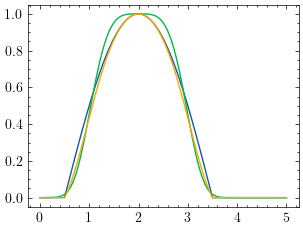

In [9]:
ts = np.linspace(0, 5, 1000)
Omega_0 = 1
Omega_center = 2
Omega_width = 1.5
sin, sin_np = get_sine(Omega_0, Omega_center, Omega_width)
fig, ax = plt.subplots()
ax.plot(ts, Omega_0 * np.sin((ts - (Omega_center - Omega_width)) * np.pi / (2 * Omega_width)) * np.heaviside(ts - (Omega_center - Omega_width), 1) * np.heaviside(-ts + (Omega_center + Omega_width), 1))
ax.plot(ts, np.exp(-1*((ts - Omega_center)**2 / (2*(Omega_width/2)**2))**2) )
# ax.plot(ts, np.exp(-1*((ts - Omega_center)**2 / (2*(Omega_width/2)**2))**1) )
ax.plot(ts, sin_np(ts), color="orange")

#### Gaussian

In [10]:
def get_gaussian(Omega_0, Omega_center, Omega_stdev):
    def gaussian(t, *args):
        return Omega_0 * np.exp(-((t - Omega_center) / Omega_stdev)**2 / 2)
    return gaussian

## Figure 1

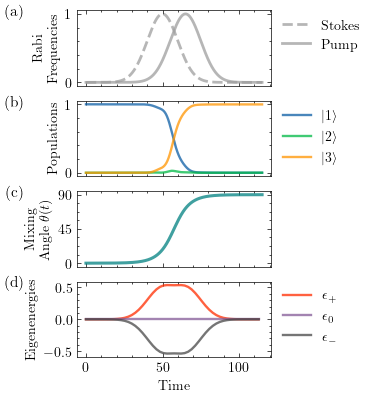

In [11]:
Delta_p = 0
Delta_s = Delta_p  # Two photon resonance

Omega_0 = 1
Omega_stdev = 10 / Omega_0
Omega_st_center = 5*Omega_stdev
Omega_pt_center = Omega_st_center + 1.5*Omega_stdev

psi0 = qt.basis(3, 0)
ts = np.linspace(0, Omega_pt_center + 5*Omega_stdev, 2000)

stokes_func= get_gaussian(Omega_0, Omega_st_center, Omega_stdev)
pump_func= get_gaussian(Omega_0, Omega_pt_center, Omega_stdev)

H = get_Hamiltonian(
    ts,
    Delta_p,
    Delta_s,
    Hs_coeff=stokes_func,
    Hp_coeff=pump_func,
    phase_noise=None,
)
output = qt.mesolve(H, psi0, ts, e_ops=e_ops)

num_ts = 50
ts_energies = [ts[j] for j in range(len(ts)) if j%int(np.ceil(len(ts) / num_ts)) == 0]
Eg, Em, Ee = np.zeros(num_ts), np.zeros(num_ts), np.zeros(num_ts)
for i in range(len(ts_energies)):
    H = get_Hamiltonian_Qobj(
        ts_energies[i],
        Delta_p,
        Delta_s,
        Hs_coeff=stokes_func,
        Hp_coeff=pump_func,
        phase_noise=None,
    )
    Eg[i], Em[i], Ee[i] = H.eigenenergies()
energies = [Eg, Em, Ee]

fig, ax = plt.subplots(4, 1, figsize=(2.5, 4.5), sharex=True)
energy_labels = [r"$\epsilon_-$", r"$\epsilon_0$", r"$\epsilon_+$"]

ax[0].plot(ts, stokes_func(ts), label=f"Stokes", color=colors[6], linestyle='--', linewidth=2., alpha=0.75)
ax[0].plot(ts, pump_func(ts), label=f"Pump", color=colors[6], linestyle='-', linewidth=2., alpha=0.75)
ax[0].set_ylabel("Rabi\nFrequencies")
ax[0].legend(bbox_to_anchor=(1.52, 1.05))

ax[1].plot(ts, output.expect[0], label=r"$|$" + f"1" + r"$\rangle$", color=colors[0], linewidth=1.7, alpha=0.75)
ax[1].plot(ts, output.expect[1], label=r"$|$" + f"2" + r"$\rangle$", color=colors[1], linewidth=1.7, alpha=0.75)
ax[1].plot(ts, output.expect[2], label=r"$|$" + f"3" + r"$\rangle$", color=colors[2], linewidth=1.7, alpha=0.75)

ax[3].plot(ts_energies, energies[2], label=energy_labels[2], color=colors[3], linewidth=1.7, alpha=0.75)
ax[3].plot(ts_energies, energies[1], label=energy_labels[1], color=colors[4], linewidth=1.7, alpha=0.75)
ax[3].plot(ts_energies, energies[0], label=energy_labels[0], color=colors[5], linewidth=1.7, alpha=0.75)

ax[1].set_ylabel("Populations")
ax[1].legend(bbox_to_anchor=(1., 1.05))

ax[2].plot(ts, np.arctan2(pump_func(ts), stokes_func(ts)) * 180 / np.pi, color="teal", linewidth=2.2, alpha=0.75)
ax[2].set_ylabel("Mixing\n" + r"Angle $\theta(t)$")
ax[2].set_yticks([0, 45, 90])

ax[3].set_ylabel("Eigenenergies")
ax[3].set_xlabel("Time")
ax[3].legend(bbox_to_anchor=(1., 1.05))


ax[0].text(-0.32, 0.98, r'(a)', transform=ax[0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1].text(-0.32, 0.98, r'(b)', transform=ax[1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[2].text(-0.32, 0.98, r'(c)', transform=ax[2].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[3].text(-0.32, 0.98, r'(d)', transform=ax[3].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 

plt.show()
# fig.savefig('img/STIRAP_sequences.png', dpi=1200)

## Figure 2

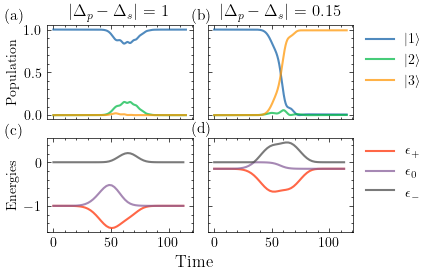

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(4.5, 2.75), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0.37, hspace=0.6)
energy_labels = [r"$\epsilon_+$", r"$\epsilon_0$", r"$\epsilon_-$"]

Delta_ps = [-1, -0.15]

for k in range(2):
    Delta_p = Delta_ps[k]
    Delta_s = 0.0 # Two photon resonance
    Omega_0 = 1
    Omega_stdev = 10 / Omega_0
    Omega_st_center = 5*Omega_stdev
    Omega_pt_center = Omega_st_center + 1.5*Omega_stdev
    
    psi0 = qt.basis(3, 0)
    ts = np.linspace(0, Omega_pt_center + 5*Omega_stdev, 2000)
    
    stokes_func= get_gaussian(Omega_0, Omega_st_center, Omega_stdev)
    pump_func= get_gaussian(Omega_0, Omega_pt_center, Omega_stdev)
    
    H = get_Hamiltonian(
        ts,
        Delta_p,
        Delta_s,
        Hs_coeff=stokes_func,
        Hp_coeff=pump_func,
        phase_noise=None,
    )
    output = qt.mesolve(H, psi0, ts, e_ops=e_ops)
    
    num_ts = 50
    ts_energies = [ts[j] for j in range(len(ts)) if j%int(np.ceil(len(ts) / num_ts)) == 0]
    Eg, Em, Ee = np.zeros(num_ts), np.zeros(num_ts), np.zeros(num_ts)
    for i in range(len(ts_energies)):
        H = get_Hamiltonian_Qobj(
            ts_energies[i],
            Delta_p,
            Delta_s,
            Hs_coeff=stokes_func,
            Hp_coeff=pump_func,
            phase_noise=None,
        )
        Eg[i], Em[i], Ee[i] = H.eigenenergies()
    energies = [Eg, Em, Ee]
    
    ax[0][k].plot(ts, output.expect[0], label=r"$|$" + f"1" + r"$\rangle$", color=colors[0], alpha=0.72, linewidth=1.5)
    ax[0][k].plot(ts, output.expect[1], label=r"$|$" + f"2" + r"$\rangle$", color=colors[1], alpha=0.72, linewidth=1.5)
    ax[0][k].plot(ts, output.expect[2], label=r"$|$" + f"3" + r"$\rangle$", color=colors[2], alpha=0.72, linewidth=1.5)
    ax[0][k].set_ylim([-0.05, 1.05])
    
    ax[1][k].plot(ts_energies, energies[0], label=energy_labels[0], color=colors[3], alpha=0.72, linewidth=1.5)
    ax[1][k].plot(ts_energies, energies[1], label=energy_labels[1], color=colors[4], alpha=0.72, linewidth=1.5)
    ax[1][k].plot(ts_energies, energies[2], label=energy_labels[2], color=colors[5], alpha=0.72, linewidth=1.5)
    
    
# ax[0][1].set_ylabel("Eigenenergies")
# ax[0][1].set_xlabel("Time")
ax[0][0].set_title(r"$|\Delta_p - \Delta_s|$ = 1")
ax[0][1].set_title(r"$|\Delta_p - \Delta_s|$ = 0.15")
ax[0][1].legend(bbox_to_anchor=(1., 1.05))
ax[1][1].legend(bbox_to_anchor=(1., 1.05))
ax[0][0].set_ylabel("Population")
ax[1][0].set_ylabel("Energies")
fig.tight_layout()
fig.supxlabel('Time', x=0.45, y=-0.02)

ax[0][0].text(-0.22, 1.1, r'(a)', transform=ax[0][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[0][1].text(-0.04, 1.1, r'(b)', transform=ax[0][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1][0].text(-0.22, 1.08, r'(c)', transform=ax[1][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1][1].text(-0.04, 1.1, r'(d)', transform=ax[1][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
plt.show()

# fig.savefig('img/delta_detuning_plots.png', dpi=1200)

## Figure 3 (Sine vs. Gaussian)

In [13]:
## Plot
Delta_p = 0
Delta_s = Delta_p  # Two photon resonance

Omega_0 = 1
Omega_stdev = 50 / Omega_0
sine_factor = 2.2

psi0 = qt.basis(3, 0)

overlaps = np.linspace(0, 4, 50) * Omega_stdev
population_in_3 = np.zeros((2, len(overlaps)))
for n in range(2):
    for j in range(len(overlaps)):
        if n == 0:
            Omega_st_center = 5*Omega_stdev
            Omega_pt_center = Omega_st_center + overlaps[j]
            ts = np.linspace(0, Omega_pt_center + 5*Omega_stdev, 2000)
            
            stokes_func= get_gaussian(Omega_0, Omega_st_center, Omega_stdev)
            pump_func= get_gaussian(Omega_0, Omega_pt_center, Omega_stdev)
            
        elif n == 1:
            Omega_st_center = 1.2*Omega_stdev
            Omega_pt_center = Omega_st_center + overlaps[j]
            ts = np.linspace(0, Omega_pt_center + 1.2*sine_factor*Omega_stdev, 2000)
            
            stokes_func, stokes_np = get_sine(Omega_0, Omega_st_center, sine_factor*Omega_stdev)
            pump_func, pump_np = get_sine(Omega_0, Omega_pt_center, sine_factor*Omega_stdev)

        H = get_Hamiltonian(
            ts,
            Delta_p,
            Delta_s,
            Hs_coeff=stokes_func,
            Hp_coeff=pump_func,
            phase_noise=None,
        )
        output = qt.mesolve(H, psi0, ts, e_ops=e_ops)
        population_in_3[n][j] = output.expect[2][-1]

<>:57: SyntaxWarning: invalid escape sequence '\O'
<>:57: SyntaxWarning: invalid escape sequence '\O'
C:\Users\jenny\AppData\Local\Temp\ipykernel_19596\3673414714.py:57: SyntaxWarning: invalid escape sequence '\O'
  yticklabels = [r'0', '$\Omega_0$', '']


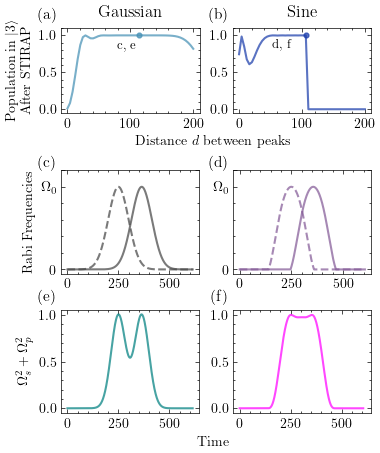

In [14]:
fig = plt.figure(figsize=(4., 5.))
outer_gs = GridSpec(2, 1, height_ratios=[0.7, 2], hspace=0.35, wspace=0.5)

top_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[0], wspace=0.24)
btm_gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_gs[1], hspace=0.35, wspace=0.25)

ax0 = fig.add_subplot(top_gs[0])
ax1 = fig.add_subplot(top_gs[1], sharey=ax0)

ax2 = fig.add_subplot(btm_gs[0,0])
ax3 = fig.add_subplot(btm_gs[0,1], sharey=ax2)
ax4 = fig.add_subplot(btm_gs[1,0])
ax5 = fig.add_subplot(btm_gs[1,1], sharey=ax4, sharex=ax2)

ax = [[ax0, ax1], [ax2, ax3], [ax4, ax5]]

Omega_st_center_gauss = 5*Omega_stdev
Omega_pt_center_opt_gauss = Omega_st_center_gauss + overlaps[np.argmax(population_in_3[0])]
stokes_gauss = get_gaussian(Omega_0, Omega_st_center_gauss, Omega_stdev)
pump_gauss = get_gaussian(Omega_0, Omega_pt_center_opt_gauss, Omega_stdev)
ts_gauss = np.linspace(0, Omega_pt_center_opt_gauss + 5*Omega_stdev, 2000)

Omega_st_center_sine = 5*Omega_stdev
Omega_pt_center_opt_sine = Omega_st_center_sine + overlaps[np.argmax(population_in_3[1])]
_, stokes_sine = get_sine(Omega_0, Omega_st_center_sine, sine_factor*Omega_stdev)
_, pump_sine = get_sine(Omega_0, Omega_pt_center_opt_sine, sine_factor*Omega_stdev)
ts_sine = np.linspace(0, Omega_pt_center_opt_sine + 5*Omega_stdev, 2000)

ax[0][0].plot(overlaps, population_in_3[0], color="#4590b5", alpha=0.72, linewidth=1.5)
ax[0][1].plot(overlaps, population_in_3[1], color="#1b3dab", alpha=0.72, linewidth=1.5)
ax[0][0].scatter(overlaps[np.argmax(population_in_3[0])], population_in_3[0][np.argmax(population_in_3[0])], s=12, color="#4590b5", alpha=0.72)
ax[0][1].scatter(overlaps[np.argmax(population_in_3[1])], population_in_3[1][np.argmax(population_in_3[1])], s=12, color="#1b3dab", alpha=0.72)
ax[0][0].text(-0.1, 1.15, r'(a)', transform=ax[0][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[0][1].text(-0.1, 1.15, r'(b)', transform=ax[0][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[0][0].text(0.47, 0.78, r'c, e', transform=ax[0][0].transAxes, fontsize=9, color='black', 
        ha='center', va='center') 
ax[0][1].text(0.35, 0.8, r'd, f', transform=ax[0][1].transAxes, fontsize=9, color='black', 
        ha='center', va='center') 
# ax[0][0].set_yscale('log')


ax[0][0].set_ylim(-0.05, 1.1)
ax[0][0].set_ylabel(r"Population in $|3 \rangle$" + "\nAfter STIRAP")
ax[0][0].set_xlabel(r"Distance $d$ between peaks", x=1.1)
ax[0][0].set_title("Gaussian", y=1.04)
ax[0][1].set_title("Sine", y=1.04)


ax[1][0].plot(ts_gauss, stokes_gauss(ts_gauss), label="Stokes", color=colors[5], alpha=0.72, linewidth=1.5, linestyle='--')
ax[1][0].plot(ts_gauss, pump_gauss(ts_gauss), label="Pump", color=colors[5],alpha=0.72, linewidth=1.5)
ax[1][1].plot(ts_sine, stokes_sine(ts_sine), label="Stokes", color=colors[4], alpha=0.72, linewidth=1.5, linestyle='--')
ax[1][1].plot(ts_sine, pump_sine(ts_sine), label="Pump", color=colors[4], alpha=0.72, linewidth=1.5)
# ax[1][0].legend(labelspacing=0.2)
yticks = [0, 1, 1.2]
yticklabels = [r'0', '$\Omega_0$', '']
ax[1][0].set_yticks(yticks)
ax[1][0].set_yticklabels(yticklabels)
ax[1][0].set_ylabel("Rabi Frequencies")

ax[1][0].text(-0.1, 1.07, r'(c)', transform=ax[1][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1][1].text(-0.1, 1.07, r'(d)', transform=ax[1][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 


# ax[2][0].plot(ts_gauss, np.arctan2(pump_gauss(ts_gauss), stokes_gauss(ts_gauss)) * 180 / np.pi, color="teal", alpha=0.72, linewidth=1.5)
# mixing_angle_data = np.zeros_like(ts_sine)
# mixing_angle_data[:int(len(ts_sine) * 3.5/5)] = np.arctan2(pump_sine(ts_sine), stokes_sine(ts_sine))[:int(len(ts_sine) * 3.5/5)]
# mixing_angle_data[int(len(ts_sine) * 3.5/5):] = np.pi/2
# ax[2][1].plot(ts_sine, mixing_angle_data * 180 / np.pi, color="magenta", alpha=0.72, linewidth=1.5)
# ax[2][0].set_yticks([0, 45, 90, 100])
# ax[2][0].set_yticklabels(['0', '45', '90', ''])
# ax[2][0].set_ylabel(r"Mixing Angle $\theta(t)$")
# ax[2][0].set_xlabel("Time", x=1.1)

ax[2][0].plot(ts_gauss, np.square(stokes_gauss(ts_gauss)) +  np.square(pump_gauss(ts_gauss)), color="teal", alpha=0.72, linewidth=1.5)
ax[2][1].plot(ts_sine, (np.square(stokes_sine(ts_sine)) +  np.square(pump_sine(ts_sine))) / np.max(np.square(stokes_sine(ts_sine)) +  np.square(pump_sine(ts_sine))), color="magenta", alpha=0.72, linewidth=1.5)
ax[2][0].text(-0.1, 1.12, r'(e)', transform=ax[2][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[2][1].text(-0.1, 1.12, r'(f)', transform=ax[2][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[2][0].set_xlabel("Time", x=1.1)
ax[2][0].set_ylabel(r"$\Omega_s^2 + \Omega_p^2$")

plt.show()
fig.savefig('img/pulse_shape_plots.png', dpi=1200)

In [15]:
overlaps[np.argmax(population_in_3[1])]

106.12244897959182

In [16]:
np.max(population_in_3[1])

0.9999910891973657

In [17]:
overlaps[np.argmax(population_in_3[0])]

114.28571428571428

In [18]:
np.max(population_in_3[0])

0.9999999991891237

## Figure 4
- Let's see how much symmetry affects the efficiency of STIRAP
- Use Gaussian shape

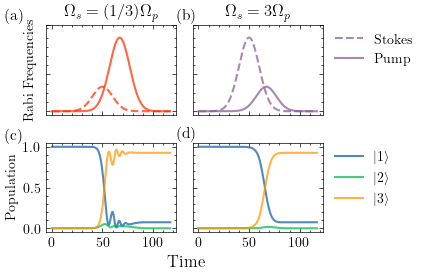

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(4.5, 2.75), sharex=True, sharey='row')
fig.subplotpars.wspace = 0.1
fig.subplotpars.hspace = 0.15

energy_labels = [r"$\epsilon_+$", r"$\epsilon_0$", r"$\epsilon_-$"]

height_factor = 3

for k in range(2):
    Delta_p = 1
    Delta_s = Delta_p # Two photon resonance
    Omega_0 = 1
    Omega_stdev = 10 / Omega_0
    Omega_st_center = 5*Omega_stdev
    Omega_pt_center = Omega_st_center + 1.7*Omega_stdev
    
    psi0 = qt.basis(3, 0)
    ts = np.linspace(0, Omega_pt_center + 5*Omega_stdev, 2000)

    if k == 0:
        stokes_func= get_gaussian(Omega_0, Omega_st_center, Omega_stdev)
        pump_func= get_gaussian(height_factor*Omega_0, Omega_pt_center, Omega_stdev)
    elif k == 1:
        stokes_func= get_gaussian(height_factor*Omega_0, Omega_st_center, Omega_stdev)
        pump_func= get_gaussian(Omega_0, Omega_pt_center, Omega_stdev)
    
    H = get_Hamiltonian(
        ts,
        Delta_p,
        Delta_s,
        Hs_coeff=stokes_func,
        Hp_coeff=pump_func,
        phase_noise=None,
    )
    output = qt.mesolve(H, psi0, ts, e_ops=e_ops)
    
    num_ts = 50
    ts_energies = [ts[j] for j in range(len(ts)) if j%int(np.ceil(len(ts) / num_ts)) == 0]
    Eg, Em, Ee = np.zeros(num_ts), np.zeros(num_ts), np.zeros(num_ts)
    for i in range(len(ts_energies)):
        H = get_Hamiltonian_Qobj(
            ts_energies[i],
            Delta_p,
            Delta_s,
            Hs_coeff=stokes_func,
            Hp_coeff=pump_func,
            phase_noise=None,
        )
        Eg[i], Em[i], Ee[i] = H.eigenenergies()
    energies = [Eg, Em, Ee]
    
    ax[1][k].plot(ts, output.expect[0], label=r"$|$" + f"1" + r"$\rangle$", color=colors[0], alpha=0.72, linewidth=1.5)
    ax[1][k].plot(ts, output.expect[1], label=r"$|$" + f"2" + r"$\rangle$", color=colors[1], alpha=0.72, linewidth=1.5)
    ax[1][k].plot(ts, output.expect[2], label=r"$|$" + f"3" + r"$\rangle$", color=colors[2], alpha=0.72, linewidth=1.5)
    ax[1][k].set_ylim([-0.05, 1.05])
    
    ax[0][k].plot(ts, stokes_func(ts), label="Stokes", color=colors[3+k], alpha=0.72, linewidth=1.5, linestyle='--')
    ax[0][k].plot(ts, pump_func(ts), label="Pump", color=colors[3+k], alpha=0.72, linewidth=1.5)
    
    
# ax[0][1].set_ylabel("Eigenenergies")
# ax[0][1].set_xlabel("Time")
ax[0][0].set_title(r"$\Omega_s = (1/3)\Omega_p$")
ax[0][1].set_title(r"$\Omega_s = 3\Omega_p$")
ax[0][1].legend(bbox_to_anchor=(1., 1.05), labelcolor='black')
for line, text in zip(plt.legend().get_lines(), plt.legend().get_texts()):
    line_color = line.get_color()
    text.set_color('black')  # Set label color to black or desired
    line.set_color('orange')

ax[1][1].legend(bbox_to_anchor=(1., 1.05))
ax[0][0].set_yticks([0, 1.5, 3.5])
ax[0][0].set_yticklabels(['', '', ''])
ax[0][0].set_ylabel("Rabi Frequencies")
ax[1][0].set_ylabel("Population")

ax[0][0].text(-0.24, 1.1, r'(a)', transform=ax[0][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[0][1].text(-0.04, 1.1, r'(b)', transform=ax[0][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1][0].text(-0.24, 1.08, r'(c)', transform=ax[1][0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1][1].text(-0.04, 1.1, r'(d)', transform=ax[1][1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
fig.tight_layout()
fig.supxlabel('Time', x=0.45, y=-0.02)
plt.show()

fig.savefig('img/diff_height_plots.png', dpi=1200)

## Figure 5

In [20]:
a0 = physical_constants['Bohr radius'][0]

In [21]:
0.018 * e * a0 * np.sqrt(2*c*4e-3) / hbar

2241110.2179099545

In [22]:
0.005 * e * a0 * np.sqrt(2*c*50e-3) / hbar 

2200978.100653597

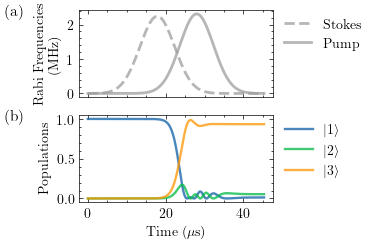

In [31]:
Delta_p = 0
Delta_s = Delta_p  # Two photon resonance

Omega_p = 0.005 * e * a0 * np.sqrt(2*c*55e-3) / hbar 
Omega_s = 0.018 * e * a0 * np.sqrt(2*c*4e-3) / hbar

Omega_stdev_s = 10 / Omega_s
Omega_stdev_p = 10 / Omega_p

Omega_st_center = 4*Omega_stdev_s
Omega_pt_center = Omega_st_center + (117 / 50)*Omega_stdev_p

psi0 = qt.basis(3, 0)
ts = np.linspace(0, Omega_pt_center + 4*Omega_stdev_p, 2000)

stokes_func = get_gaussian(Omega_s, Omega_st_center, Omega_stdev_s)
pump_func = get_gaussian(Omega_p, Omega_pt_center, Omega_stdev_p)

H = get_Hamiltonian(
    ts,
    Delta_p,
    Delta_s,
    Hs_coeff=stokes_func,
    Hp_coeff=pump_func,
    phase_noise=None,
)
output = qt.mesolve(H, psi0, ts, e_ops=e_ops)

num_ts = 50
ts_energies = [ts[j] for j in range(len(ts)) if j%int(np.ceil(len(ts) / num_ts)) == 0]
Eg, Em, Ee = np.zeros(num_ts), np.zeros(num_ts), np.zeros(num_ts)
for i in range(len(ts_energies)):
    H = get_Hamiltonian_Qobj(
        ts_energies[i],
        Delta_p,
        Delta_s,
        Hs_coeff=stokes_func,
        Hp_coeff=pump_func,
        phase_noise=None,
    )
    Eg[i], Em[i], Ee[i] = H.eigenenergies()
energies = [Eg, Em, Ee]

fig, ax = plt.subplots(2, 1, figsize=(2.5, 2.5), sharex=True)
energy_labels = [r"$\epsilon_-$", r"$\epsilon_0$", r"$\epsilon_+$"]

ax[0].plot(ts/1e-6, stokes_func(ts)/1e6, label=f"Stokes", color=colors[6], linestyle='--', linewidth=2., alpha=0.75)
ax[0].plot(ts/1e-6, pump_func(ts)/1e6, label=f"Pump", color=colors[6], linestyle='-', linewidth=2., alpha=0.75)
ax[0].set_ylabel("Rabi Frequencies\n(MHz)")
ax[0].legend(bbox_to_anchor=(1.52, 1.05))

ax[1].plot(ts/1e-6, output.expect[0], label=r"$|$" + f"1" + r"$\rangle$", color=colors[0], linewidth=1.7, alpha=0.75)
ax[1].plot(ts/1e-6, output.expect[1], label=r"$|$" + f"2" + r"$\rangle$", color=colors[1], linewidth=1.7, alpha=0.75)
ax[1].plot(ts/1e-6, output.expect[2], label=r"$|$" + f"3" + r"$\rangle$", color=colors[2], linewidth=1.7, alpha=0.75)

# ax[3].plot(ts_energies, energies[2], label=energy_labels[2], color=colors[3], linewidth=1.7, alpha=0.75)
# ax[3].plot(ts_energies, energies[1], label=energy_labels[1], color=colors[4], linewidth=1.7, alpha=0.75)
# ax[3].plot(ts_energies, energies[0], label=energy_labels[0], color=colors[5], linewidth=1.7, alpha=0.75)

ax[1].set_ylabel("Populations")
ax[1].legend(bbox_to_anchor=(1., 1.05))
ax[1].set_xlabel(r"Time ($\mu$s)")
# ax[1].set_xticks([0, 100, 200, 300, 400])
# ax[2].plot(ts, np.arctan2(pump_np(ts), stokes_np(ts)) * 180 / np.pi, color="teal", linewidth=2.2, alpha=0.75)
# ax[2].set_ylabel("Mixing\n" + r"Angle $\theta(t)$")
# ax[2].set_yticks([0, 45, 90])

# ax[3].set_ylabel("Eigenenergies")
# ax[3].set_xlabel("Time")
# ax[3].legend(bbox_to_anchor=(1., 1.05))


ax[0].text(-0.33, 0.98, r'(a)', transform=ax[0].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
ax[1].text(-0.33, 0.98, r'(b)', transform=ax[1].transAxes, fontsize=11, color='black', 
        ha='center', va='center') 
# ax[2].text(-0.32, 0.98, r'(c)', transform=ax[2].transAxes, fontsize=11, color='black', 
#         ha='center', va='center') 
# ax[3].text(-0.32, 0.98, r'(d)', transform=ax[3].transAxes, fontsize=11, color='black', 
#         ha='center', va='center') 

plt.show()
fig.savefig('img/KRb_parameters.png', dpi=1200)

In [43]:
print(f"Omega_p: {Omega_p / 1e6 : .2f} MHz" )
print(f"Omega_s: {Omega_s / 1e6 : .2f} MHz" )
print(f"Tau: {10/Omega_s / 1e-6 : .3f} us")
print(f"Distance between peaks: {(117 / 50)*Omega_stdev_p / 1e-6 : .2f} us")
print(f"|3>: {output.expect[2][-1] :.3f}")

Omega_p:  2.31 MHz
Omega_s:  2.24 MHz
Tau:  4.462 us
Distance between peaks:  10.14 us
|3>: 0.934
